In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Input
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import TopKCategoricalAccuracy

from sklearn.model_selection import train_test_split

retrain_model = False

In [4]:
from tensorflow.keras.datasets import cifar100

(X_train, y_train), (X_test, y_test) = cifar100.load_data()

# Normalize X data
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)


In [5]:
# Convert labels to one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, 100)
y_test = tf.keras.utils.to_categorical(y_test, 100)

In [6]:
# Define the enhanced CNN model
model = Sequential([
    Input(shape=(32, 32, 3)),

    # Block 1
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    # Block 2
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    # Block 3
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),

    # Global Average Pooling instead of Dense(256)
    GlobalAveragePooling2D(),

    # Final output layer
    Dense(100, activation='softmax')
])


2025-04-23 10:33:34.452818: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-23 10:33:34.452870: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:


# Callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss', patience=25, restore_best_weights=True, verbose=1
    ),
    ModelCheckpoint(
        filepath='best_model.h5', monitor='val_loss', save_best_only=True, verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1
    )
]



In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an augmented data generator
datagen = ImageDataGenerator(
    rotation_range=20,      # Random rotations within 20 degrees
    width_shift_range=0.2,  # Horizontal shifts
    height_shift_range=0.2, # Vertical shifts
    shear_range=0.2,        # Shear transformations
    zoom_range=0.2,         # Random zoom
    horizontal_flip=True,   # Flip images horizontally
    fill_mode='nearest'     # Fill pixels for rotated/shifts
)



# Fit the generator to training data
# datagen.fit(X_train)

# # Use .flow() to get batches from datagen
# train_generator = datagen.flow(X_train, y_train, batch_size=64)


In [9]:

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [14]:
X_training, X_val, y_training, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

datagen.fit(X_training)
# Use .flow() to get batches from datagen
train_generator = datagen.flow(X_training, y_training, batch_size=64)

# Use generator during model training
if retrain_model:
    history = model.fit(
        train_generator,
        validation_data=(X_val, y_val),
        epochs=60,
        callbacks=callbacks,
        verbose=2
    )
else:
    model = load_model('best_model.h5')

In [15]:
history.history.keys()

NameError: name 'history' is not defined

In [16]:
if retrain_model:
    pd.DataFrame({"epoch": history.epoch,
                "learning_rate": history.history["lr"],
                "loss": history.history["loss"],
                "val_loss": history.history["val_loss"],
                "accuracy": history.history["accuracy"],
                "val_accuracy": history.history["val_accuracy"]})

    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"], label="loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.plot(history.history["lr"], label="learning_rate")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history["accuracy"], label="accuracy")
    plt.plot(history.history["val_accuracy"], label="val_accuracy")
    plt.plot(history.history["lr"], label="learning_rate")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

In [17]:
# Evaluate the model

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Accuracy: {test_acc * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


2025-04-23 10:37:06.905229: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 - 5s - loss: 2.3834 - accuracy: 0.3962 - 5s/epoch - 17ms/step
Test Accuracy: 39.62%
Test Loss: 2.3834


In [18]:
model.inputs, model.input, model.input_shape

([<KerasTensor: shape=(None, 32, 32, 3) dtype=float32 (created by layer 'input_1')>],
 <KerasTensor: shape=(None, 32, 32, 3) dtype=float32 (created by layer 'input_1')>,
 (None, 32, 32, 3))

In [19]:
X_test[0].shape

(32, 32, 3)

Keras models always expect a batch (even if it’s a batch of 1), so the input must have shape (1, 32, 32, 3) instead of just (32, 32, 3).

In [20]:
# Expand dimensions to make it a batch of 1
single_image = np.expand_dims(X_test[0], axis=0)
print("Single image shape:", single_image.shape)
# Predict
prediction = model.predict(single_image)
print(prediction)

Single image shape: (1, 32, 32, 3)
1/1 [==============================] - 0s 233ms/step
[[2.37149223e-07 4.12118534e-05 1.53200526e-03 3.96774383e-03
  7.51744024e-03 4.69978084e-04 1.67926002e-04 5.23810554e-03
  1.07045630e-02 2.51524674e-04 9.71035275e-04 3.39259021e-03
  3.70535515e-02 5.08168305e-04 9.54703282e-05 4.89192200e-04
  1.56211143e-04 1.04416395e-03 3.28614726e-03 2.08892990e-04
  8.46522671e-05 3.43682041e-04 1.87473500e-03 2.84393709e-02
  9.60694067e-03 1.46232356e-04 5.61104203e-03 3.23584001e-03
  2.49217846e-04 2.43873917e-03 1.17426492e-01 3.98963224e-04
  8.48294981e-03 5.02149633e-04 1.50342903e-03 1.13054912e-03
  5.80854714e-04 1.87030726e-03 2.23312364e-03 3.20683233e-02
  3.11852607e-04 2.31943995e-04 5.06488490e-04 3.94245813e-04
  4.63206926e-03 8.50585988e-04 2.77312892e-03 1.16492156e-04
  7.43910030e-04 4.76422012e-01 4.16228361e-03 4.53970642e-05
  1.38011401e-05 1.43452166e-06 1.10355417e-04 8.79595149e-03
  1.39611482e-03 2.59619719e-05 1.37277937e-

2025-04-23 10:37:20.069228: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Predicted class index: 49


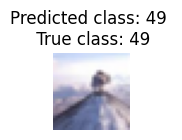

In [21]:
predicted_class = np.argmax(prediction)

print("Predicted class index:", predicted_class)

#Visualize the prediction with image
plt.figure(figsize=(1,1))
plt.imshow(X_test[0])
plt.title(f"Predicted class: {predicted_class} \n True class: {np.argmax(y_test[0])}")
plt.axis('off')
plt.show()


In [22]:
# Get predicted class probabilities
y_pred_probs = model.predict(X_test)

# Convert probabilities to class labels
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test, axis=1)


313/313 [==============================] - 1s 5ms/step


In [35]:
from sklearn.metrics import classification_report
# Print classification report
csr = classification_report(y_true_classes, y_pred_classes, output_dict=True)

# Confusion Matrix doesn't help here due to large number of classes.

In [36]:
csr = pd.DataFrame(csr).T

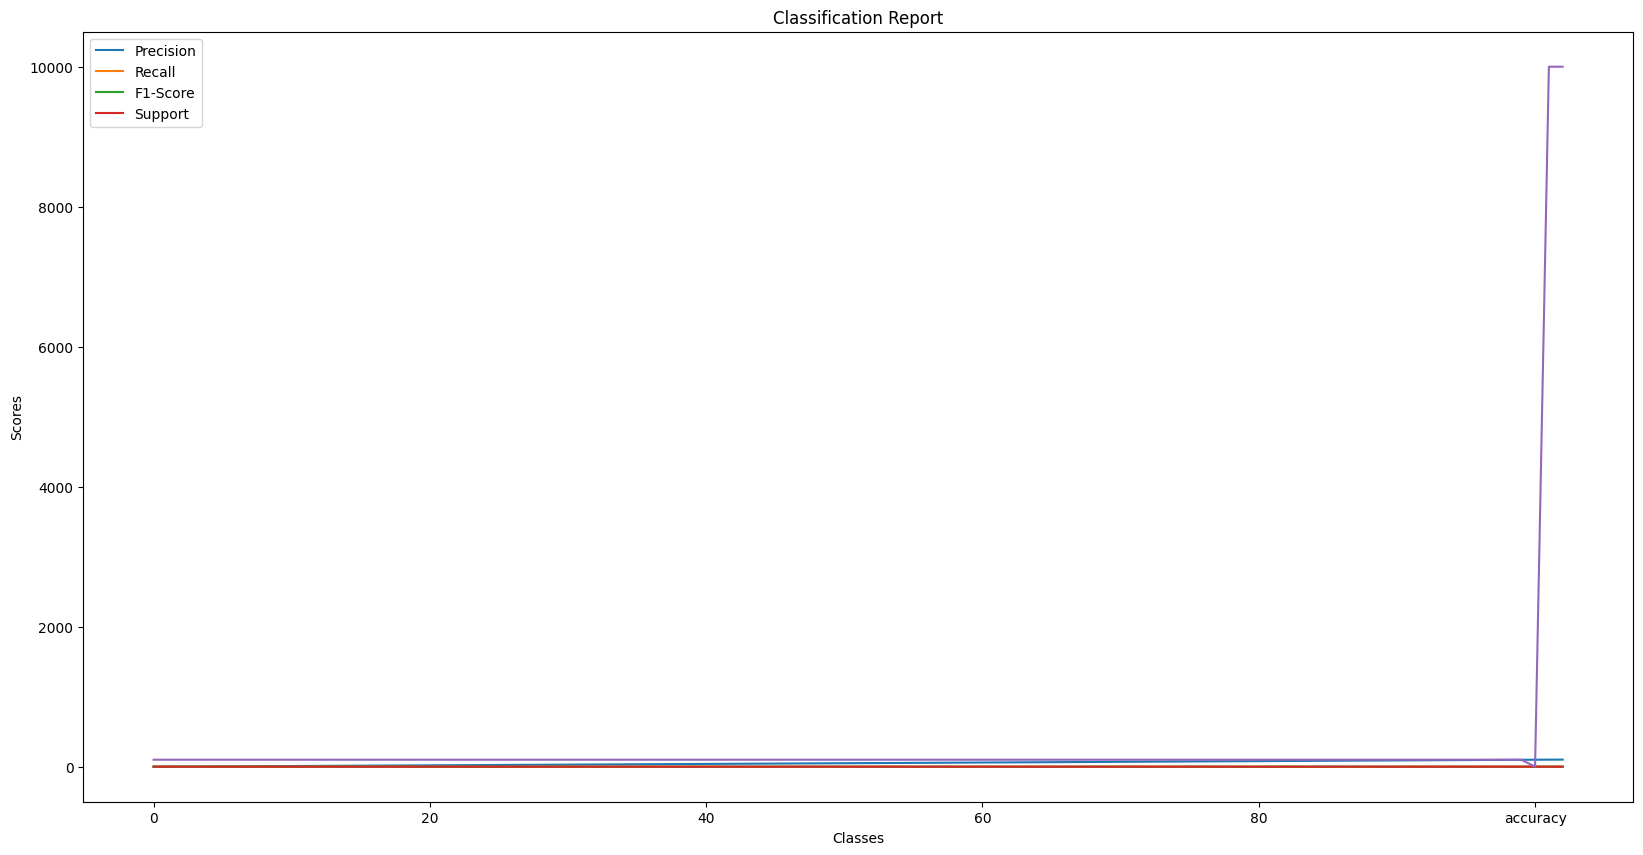

In [40]:
csr = csr.reset_index()
csr.plot(x='index', figsize=(20,10))
plt.title("Classification Report")
plt.xlabel("Classes")
plt.ylabel("Scores")
plt.legend(["Precision", "Recall", "F1-Score", "Support"])
plt.show()

In [42]:
csr.sort_values(by='f1-score', ascending=False, inplace=True)

In [43]:
csr

,level_0,index,precision,recall,f1-score,support
60,60,60,0.682171,0.88,0.768559,100.0
82,82,82,0.680672,0.81,0.739726,100.0
53,53,53,0.653543,0.83,0.731278,100.0
68,68,68,0.717172,0.71,0.713568,100.0
0,0,0,0.761364,0.67,0.712766,100.0
...,...,...,...,...,...,...
38,38,38,0.352941,0.06,0.102564,100.0
44,44,44,0.142857,0.06,0.084507,100.0
98,98,98,0.185185,0.05,0.078740,100.0
10,10,10,0.230769,0.03,0.053097,100.0
